In [3]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
data_dir = "data/"
dataObject = xrdData("data/", device)

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataObject.torch_datasets['val'], batch_size=32, shuffle=False)
simulator = ExperimentalSimulation(device, crop_start=500, crop_stop = 500, noise_range = 0.1, drop_width = 100, drop_freq = 2) 

In [5]:
class RegularizedLoss(nn.Module):
    def __init__(self, model, criterion=nn.CrossEntropyLoss(), l1=0, l2=0, full=True):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.full = full
        
        self.l1 = l1
        self.l2 = l2

    def __call__(self, pred, target):
        # print(self.criterion)
        loss = self.criterion(pred, target)
        # print(loss)
        l1_reg = torch.tensor(0., requires_grad=True)
        l2_reg = torch.tensor(0., requires_grad=True)
        for name, param in self.model.named_parameters():
            if 'weight' in name and (self.full or 'elem_former' in name):
                # print(torch.sum(torch.abs(param), dim=None))
                # print(l1_reg)
                l1_reg = l1_reg + torch.sum(torch.abs(param), dim=None)
                # l2_reg = l2_reg + torch.sqrt(torch.sum(torch.pow(param, 2), dim=None))
        # print(l1_reg)
        # print(loss, self.l2 * l2_reg)
        return loss + self.l1 * l1_reg + self.l2 * l2_reg

In [31]:
import pandas as pd
max_epochs = 125
metrics = ["accuracy", "loss"]

log = {
    f"{type}": {f"{metric}" : np.zeros(max_epochs) for metric in metrics} for type in ['train', 'val']     
}

model_df = pd.DataFrame(columns=['model', 'epoch', 'type', 'loss', 'accuracy'])
model_df

,model,epoch,type,loss,accuracy


In [6]:
model_df = pd.read_pickle('regularized_model_data.pkl')
model_df

,model,epoch,type,loss,accuracy
0,unregularized,0,train,3.195797,26.392157
1,unregularized,0,valid,2.701790,35.888141
2,unregularized,1,train,2.522698,38.575163
3,unregularized,1,valid,2.304310,43.293630
4,unregularized,2,train,2.227118,44.650327
...,...,...,...,...,...
1195,no_dropout,97,valid,4.745479,49.585707
1196,no_dropout,98,train,0.040592,99.104575
1197,no_dropout,98,valid,5.074461,49.093734
1198,no_dropout,99,train,0.031727,99.202614


In [39]:
def train_loop(fname='train'):
    final_epoch = 0
    try:
        for epoch in range(max_epochs):
            model.train()  # Set the model to training mode
            total_train_loss = 0
            correct_train = 0
            total_train = 0
            
            for xrd, composition, targets in tqdm(train_loader):
                xrd = simulator.sim(xrd)
                optimizer.zero_grad()
                outputs = model(xrd, composition)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
        
                _, predicted = torch.max(outputs.data, 1)
                
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()
        
            train_accuracy = 100 * correct_train / total_train
            
            # Validation phase
            model.eval()  # Set the model to evaluation mode
            total_valid_loss = 0
            correct_valid = 0
            total_valid = 0
        
            with torch.no_grad():  # No gradients needed for validation
                for xrd, composition, targets in tqdm(valid_loader):
                    xrd = simulator.sim(xrd)
                    outputs = model(xrd, composition)
                    loss = criterion(outputs, targets)
                    total_valid_loss += loss.item()
        
                    _, predicted = torch.max(outputs.data, 1)
                    
                    total_valid += targets.size(0)
                    correct_valid += (predicted == targets).sum().item()
        
            valid_accuracy = 100 * correct_valid / total_valid
        
            train_loss = total_train_loss / len(train_loader)
            valid_loss = total_valid_loss / len(valid_loader)
        
            print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}%")
        
            # log['train']['accuracy'][epoch] = (train_accuracy)
            # log['train']['loss'][epoch] =(total_train_loss)
        
            # log['val']['accuracy'][epoch] =(valid_accuracy)
            # log['val']['loss'][epoch] =(validation_loss)
            
            model_df.loc[len(model_df)] = [fname, epoch, 'train', train_loss, train_accuracy]
            model_df.loc[len(model_df)] = [fname, epoch, 'valid', valid_loss, valid_accuracy]
        
            final_epoch = epoch
            
    except KeyboardInterrupt:
        print(f'Interrupting training at epoch {final_epoch}')
        

    # plt.plot(log['train']['accuracy'][:final_epoch])
    # plt.plot(log['val']['accuracy'][:final_epoch])
    # plt.savefig(f'{fname}.png')

    return final_epoch

In [34]:
# Create the model instance and move it to the selected device
output_dim = 230  # Output dimension
ConvModel = XRD_C_SymNet(in_channels=1, output_dim=output_dim, composition_model= None).to(device)
token_size = 10 #dimension of the tokens 
TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
model = TransModel

# Define optimizer and loss function
weight_decay = 0  # Example value, adjust based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/home/lcl35/.conda/envs/cpsc552v2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


12160
torch.Size([40, 80])
torch.Size([80, 40])


<Axes: xlabel='epoch', ylabel='accuracy'>

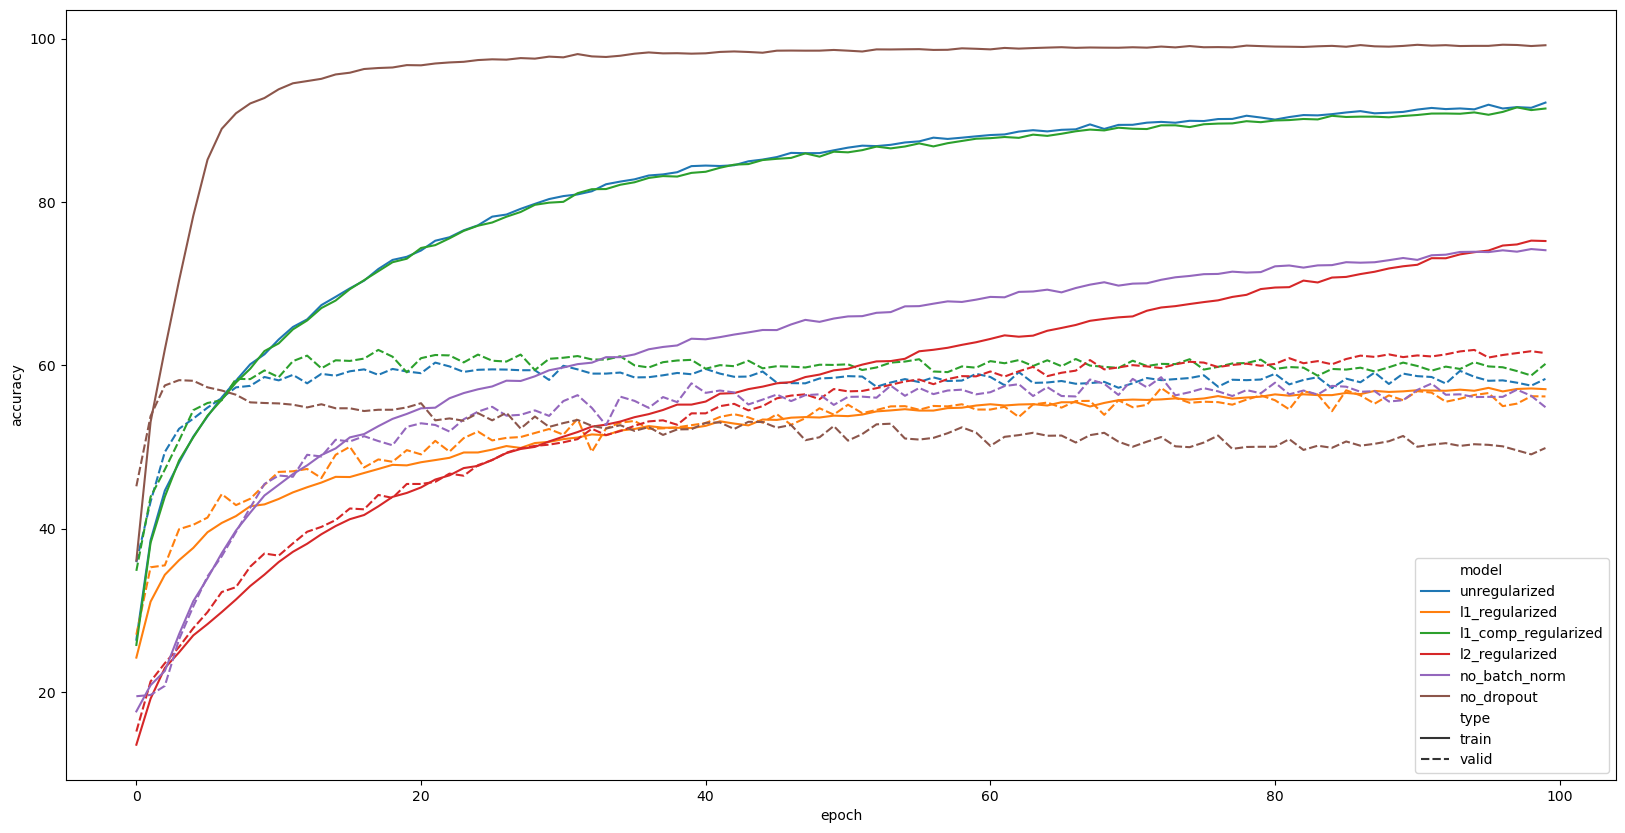

In [12]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.lineplot(data=model_df, x='epoch', y='accuracy', hue='model', style='type')

<Axes: xlabel='epoch', ylabel='loss'>

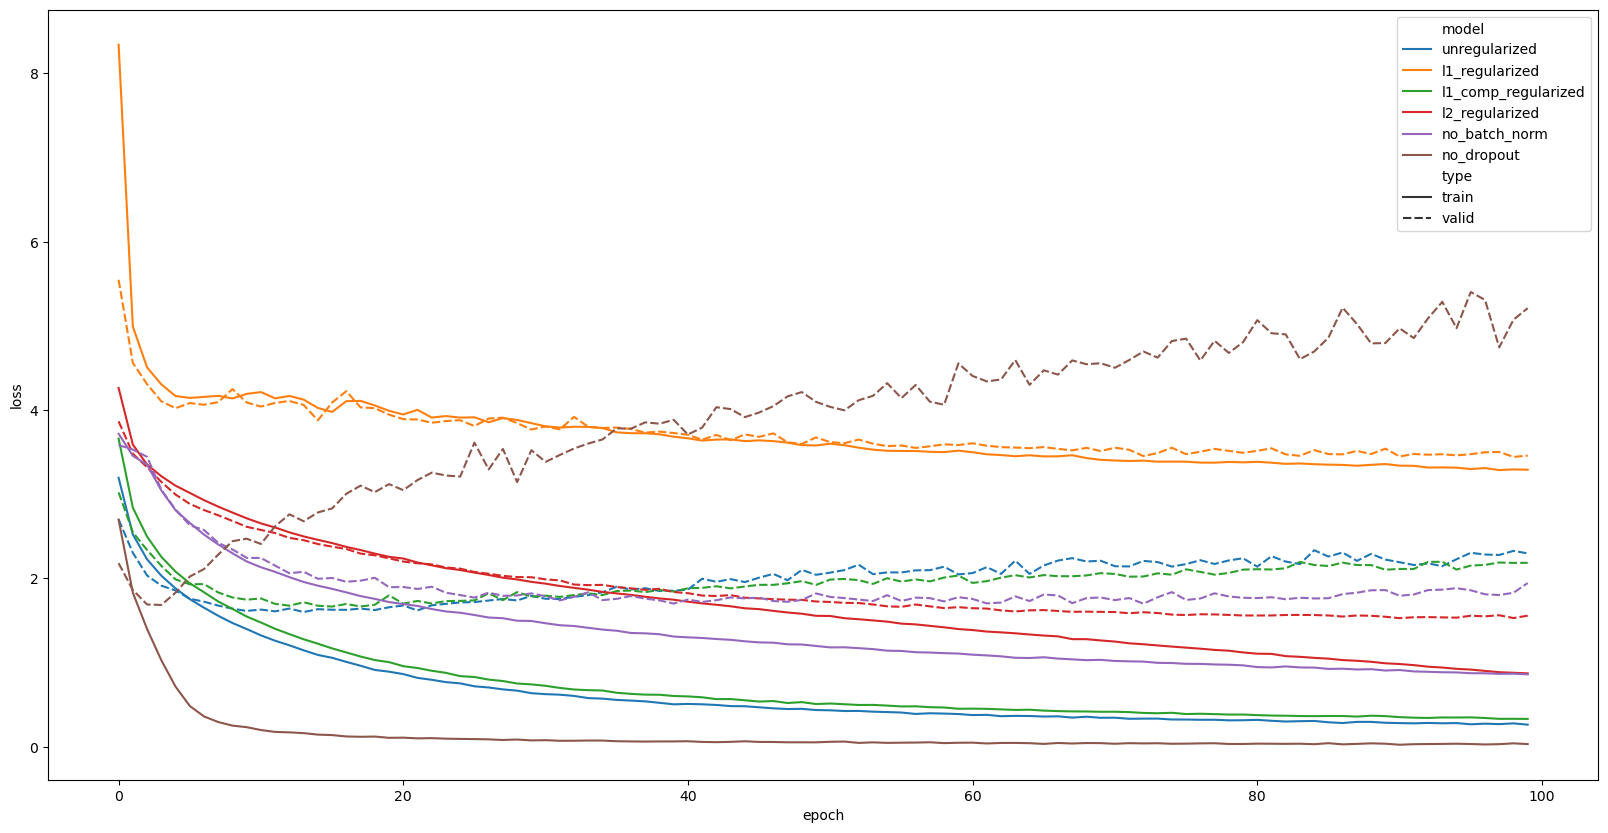

In [13]:
sns.lineplot(data=model_df, x='epoch', y='loss', hue='model', style='type')